In [1]:
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import shapely

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import preprocessing as pp
import data_loading as data
import anomalies as an
import estimations as em
import visualize as vz

### Configuration of area and time

In [3]:
copernicushub_config = data.create_configuration(
    client_id="sh-e670f9d0-df66-4f6f-aed0-fccc6f1f871f", 
    client_secret="Iih2YwJFxVydRB7HG9j2x6PRn1M74GxP"
)

In [4]:
crs = data.CRS(32632)
small_ticino = {'bbox': shapely.box(489152.05, 5029502.98, 494849.52, 5036759.13).bounds,
                'crs': crs}

In [5]:
time_range = (dt.date(2017, 1, 1), dt.date(2022, 12, 31))

### Load data (will access copernicushub)

In [6]:
images = data.load_satellite_images(config=copernicushub_config,
                                    aoi=small_ticino, 
                                    time_range=time_range, 
                                    file_path=Path("small_test_data"), 
                                    show_progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 425/425 [00:00<00:00, 79590.09image/s]


### Example with single recording

In [35]:
dataset = em.create_dataset(images[0])

In [36]:
lai = em.estimate_lai(dataset)
cwc = em.estimate_cwc(dataset)
ccc = em.estimate_ccc(dataset)

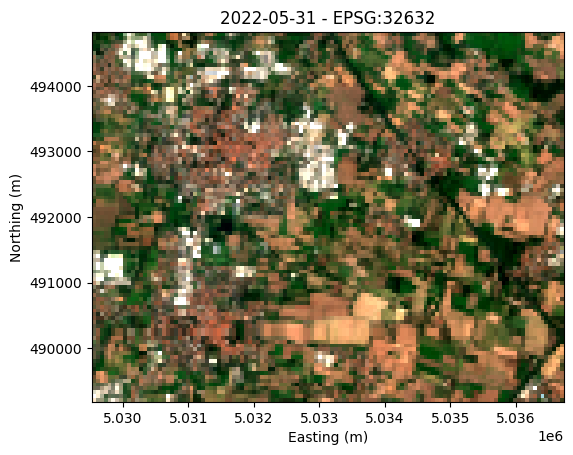

In [37]:
vz.plot_satellite_image(dataset)

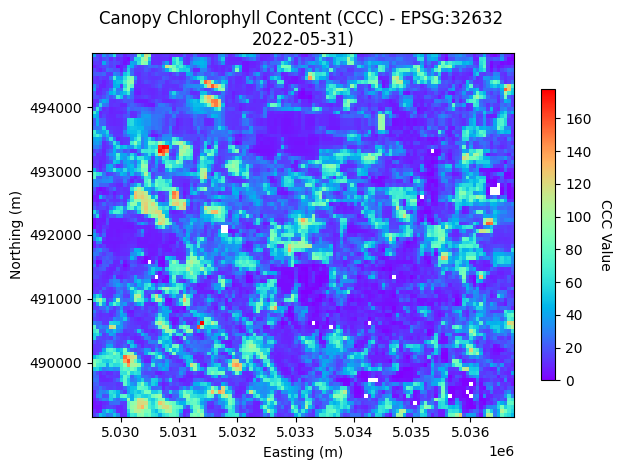

In [48]:
vz.plot_biophys_result(ccc, "rainbow")

In [10]:
# currently no metadata is stored in the tiff
data.save_as_tiff(ccc, f"{images[0]['name']}_ccc.tiff")

### Anomaly example over whole dataset

In [10]:
ccc = an.create_time_series(images, em.BiophysicalVariable.CCC)

In [11]:
interpolated = an.fill_gaps_and_smooth_data(ccc)

In [12]:
anomaly = an.compute_sda_for_dayofyear(interpolated, dt.date(2022,6,30))

#### About white pixels / na-values:
Some values (white pixels) have NA values which arise from the `masked=True` argument in the reading of the file.
Satellite images may contain a mask, e.g. due to high cloud coverage on the pixels, thus they are being neglected -> set to NA. 
I assume this is useful in this scenario, as they could contribute to weird behaviour in anomaly / biophys computations. 

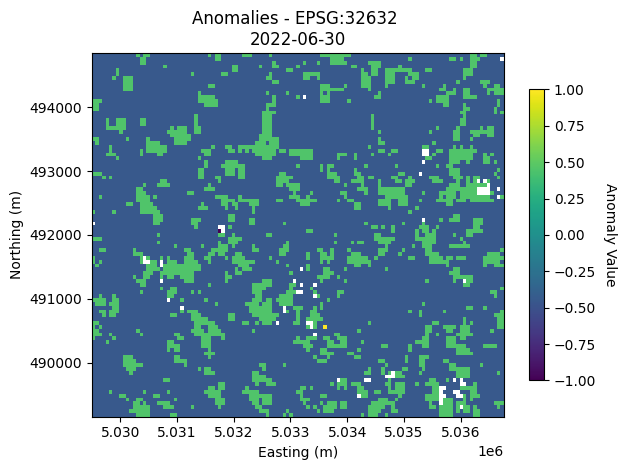

In [14]:
vz.plot_anomalies(anomaly, cmap="viridis")

### Final Steps

Done:
- Add crs to biophys, anomaly results
- Remove unneccessary warnings
- Analyze additional warnings (only about NA values maybe?)
- Add date to plot
- Remove credentials and test setup


- correct rotation of image
- Add Readme.md

# About leap years:
The grouping assigns each day of year a value of 1-365/366, depending wether it is leap year or not.
This leads to the issue, that in this year all values starting from 29th of February are one higher than every other year. 

What to do about it:
- One option would be just to neglect it, as the values should not vary much just because of a 1-day difference. The issue is that if I want to analyze an exact date, it would be hard to comprehend which day exactly is being analyzed. 
- Another approach would be to enumerate the days of the year to 366 for every single year. This means, that one value of the series will not be present for 3 of 4 years. 